In [1212]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_validate,KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [1213]:
def encoding(values, columnData, setDatos):
    df = pd.DataFrame()
    column = columnData
    if(setDatos=='set_train'):
        df[values] = pd.get_dummies(set_train[column])
    else:
        df[values] = pd.get_dummies(test_values[column])
    df['sumatory'] = 0
    for i in range(len(values)):
        df['sumatory'] += df[values[i]] * df[values[i]].mean()
    
    return df['sumatory']

In [1214]:
train_values = pd.read_csv('train_values.csv')
train_labels = pd.read_csv('train_labels.csv')
test_values = pd.read_csv('test_values.csv',index_col='building_id')

In [1215]:
set_train = train_values.merge(train_labels)
set_train.drop( columns=["building_id"], inplace=True)
set_train = set_train[set_train['count_floors_pre_eq'] <= 6]

In [1216]:
#promedio = set_train['age'].mean()
#b = set_train['age'].values.tolist()
#b = [promedio if x > 100 else x for x in b]
#set_train['age'] = b

In [1217]:
#promedio2 = set_train['count_floors_pre_eq'].mean()
#a = set_train['count_floors_pre_eq'].values.tolist()
#a = [promedio2 if x > 5 else x for x in a]
#set_train['count_floors_pre_eq'] = a

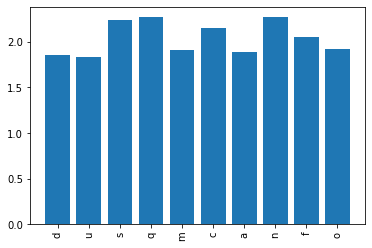

In [1218]:
plan_configuration = pd.DataFrame()
plan_configuration[['d', 'u', 's', 'q', 'm', 'c', 'a', 'n', 'f', 'o']]= pd.get_dummies(set_train['plan_configuration'])

plan_configuration['damage_grade'] = set_train['damage_grade']
vector_names = ['d', 'u', 's', 'q', 'm', 'c', 'a', 'n', 'f', 'o']
promedios = []
for x in range(len(vector_names)):
    aux = plan_configuration.loc[plan_configuration[vector_names[x]] == 1,:]
    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

plt.bar(vector_names, promedios)
plt.xticks(rotation=90)
plt.show()

#count_families = pd.DataFrame()
#count_families[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']] = pd.get_dummies(set_train['count_families'])
#count_families

#count_families['damage_grade'] = set_train['damage_grade']
#vector_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#promedios = []
#for x in range(len(vector_names)):
#    aux = count_families.loc[count_families[vector_names[x]] == 1,:]
#    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

#plt.bar(vector_names, promedios)
#plt.xticks(rotation=90)
#plt.show()

In [1219]:
plan_configuration.sum()

d                  252
u                  324
s               250033
q                   22
m                   46
c                   38
a                  159
n                 5692
f                  346
o                 3648
damage_grade    583221
dtype: int64

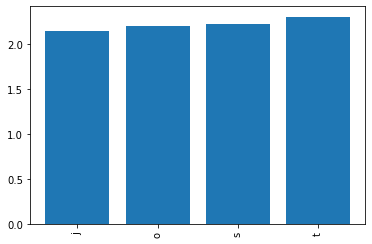

In [1220]:
position = pd.DataFrame()
position= pd.get_dummies(set_train['position'])

position['damage_grade'] = set_train['damage_grade']
vector_names = ['j', 'o', 's', 't']
promedios = []
for x in range(len(vector_names)):
    aux = position.loc[position[vector_names[x]] == 1,:]
    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

plt.bar(vector_names, promedios)
plt.xticks(rotation=90)
plt.show()

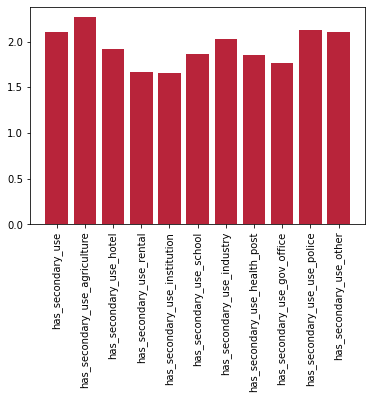

In [1221]:
secondary_use = set_train.iloc[:,27:38]
secondary_use['damage_grade'] = set_train['damage_grade']
vector_names = ['has_secondary_use','has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental',
               'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 
               'has_secondary_use_health_post', 'has_secondary_use_gov_office','has_secondary_use_use_police',
               'has_secondary_use_other']
promedios = []
for x in range(len(vector_names)):
    aux = secondary_use.loc[secondary_use[vector_names[x]] == 1,:]
    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

plt.bar(vector_names, promedios, color='#B8243A')
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:>

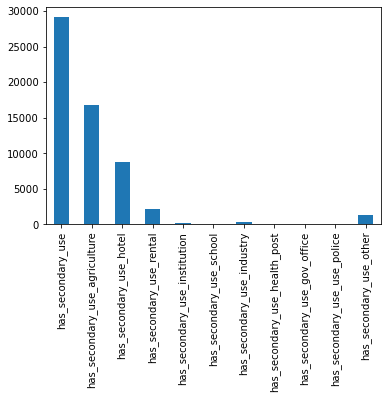

In [1222]:
set_train.iloc[:, 27:38].sum().plot.bar()

In [1223]:
drop_columns = set_train.columns.values[26:38]
#set_train.drop(columns= drop_columns, inplace = True)

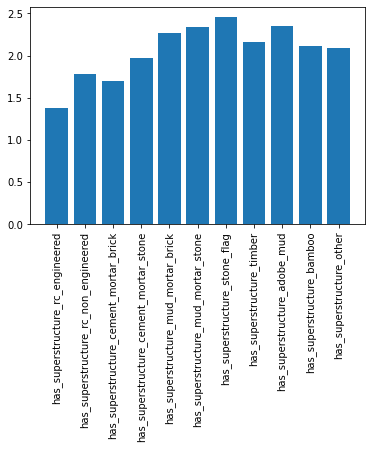

In [1224]:
materiales = set_train.iloc[:,14:25]
materiales['damage_grade'] = set_train['damage_grade']
#vector_names = ['has_superstructure_rc_engineered','has_superstructure_cement_mortar_brick', 'has_superstructure_rc_non_engineered',
 #              'has_superstructure_cement_mortar_stone','has_superstructure_other', 'has_superstructure_bamboo',
  #              'has_superstructure_timber', 
   #             'has_superstructure_mud_mortar_brick', 'has_superstructure_mud_mortar_stone',
    #            'has_superstructure_adobe_mud','has_superstructure_stone_flag']

vector_names = ['has_superstructure_rc_engineered', 'has_superstructure_rc_non_engineered', 'has_superstructure_cement_mortar_brick',
               'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_mud_mortar_stone',
               'has_superstructure_stone_flag', 'has_superstructure_timber', 'has_superstructure_adobe_mud', 
               'has_superstructure_bamboo', 'has_superstructure_other']
promedios = []
for x in range(len(vector_names)):
    aux = materiales.loc[materiales[vector_names[x]] == 1,:]
    promedios.append(aux['damage_grade'].sum() / aux[vector_names[x]].sum())

plt.bar(vector_names,promedios )
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:>

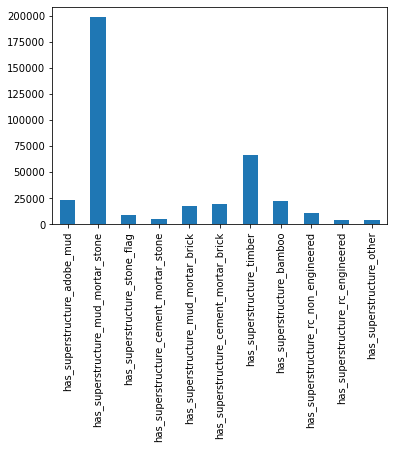

In [1225]:
set_train.iloc[:, 14:25].sum().plot.bar()

In [1226]:
values = [1, 0.9, 0.85, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
for i in range(11):
    set_train.loc[:, [vector_names[i]]] = set_train.loc[:, [vector_names[i]]]*values[i]

In [1227]:
set_train['resistance'] = 0
for x in range(11):
    set_train['resistance'] += set_train[vector_names[x]]
set_train['resistance'].head()

0    0.7
1    0.5
2    0.5
3    0.9
4    0.2
Name: resistance, dtype: float64

In [1228]:
set_train[['position_j', 'position_o', 'position_s', 'position_t']] = pd.get_dummies(set_train['position'])
set_train[['owner_a', 'owner_r', 'owner_v', 'owner_w']]= pd.get_dummies(set_train['legal_ownership_status'])

In [1229]:
set_train['base_condition'] = encoding(['h', 'i', 'r', 'u', 'w'] , 'foundation_type', 'set_train') + encoding(['n', 'o', 't'] , 'land_surface_condition', 'set_train')

In [1230]:
set_train['roof_type'] = encoding(['n', 'q', 'x'] , 'roof_type', 'set_train')
set_train['ground_floor_type'] = encoding(['f','m','v','x','z'] , 'ground_floor_type', 'set_train')
set_train['other_floor_type'] = encoding(['j','q','s','x'] , 'other_floor_type', 'set_train')

In [1231]:
columnas_seleccionads = ['age',
                         'geo_level_1_id',
                         'area_percentage',
                         'count_floors_pre_eq',
                         'geo_level_2_id',
                         'height_percentage',
                         'resistance',
                         'roof_type',
                         'ground_floor_type',
                         'other_floor_type',
                         'position_j', 'position_o', 
                         'position_s', 'position_t',
                          'uso_secundario',
                          'prom_heigh_floor',
                         'base_condition',
                          'damage_grade'
                         ]

In [1232]:
#set_train['volume_percentage'] = set_train['height_percentage']*set_train['area_percentage']

In [1233]:
columnas_seleccionadas= ['age', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
'count_floors_pre_eq', 'area_percentage', 'height_percentage', 'count_families',
'has_secondary_use','has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental',
'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 
'has_secondary_use_health_post', 'has_secondary_use_gov_office','has_secondary_use_use_police',
'has_secondary_use_other',
'has_superstructure_rc_engineered', 'has_superstructure_rc_non_engineered', 'has_superstructure_cement_mortar_brick',
'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_mud_mortar_stone',
'has_superstructure_stone_flag', 'has_superstructure_timber', 'has_superstructure_adobe_mud', 
'has_superstructure_bamboo', 'has_superstructure_other', 
'roof_type_n', 'roof_type_q', 'roof_type_x',
'ground_floor_type_f','ground_floor_type_m',
'ground_floor_type_v','ground_floor_type_x',
'ground_floor_type_z',
'other_floor_type_j','other_floor_type_q',
'other_floor_type_s','other_floor_type_x',
'foundation_type_h', 'foundation_type_i', 
'foundation_type_r', 'foundation_type_u', 
'foundation_type_w', 'land_surface_condition_n', 
'land_surface_condition_o', 'land_surface_condition_t',
'position_j', 'position_o', 
'position_s', 'position_t',
'plan_configuration_d', 'plan_configuration_u', 
'plan_configuration_s', 'plan_configuration_q', 
'plan_configuration_m', 'plan_configuration_c', 
'plan_configuration_a', 'plan_configuration_n', 
'plan_configuration_f', 'plan_configuration_o',
'base_condition', 'prom_heigh_floor', 'uso_secundario', 
'roof_type', 'ground_floor_type', 'other_floor_type', 
                         'resistance',
'damage_grade'
]

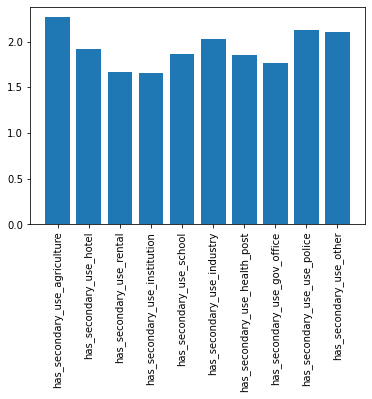

In [1234]:
uso_secundario = set_train.iloc[:,27:38]
uso_secundario['damage_grade'] = set_train['damage_grade']
vector_secundario = [        'has_secondary_use_agriculture', 
                         'has_secondary_use_hotel', 'has_secondary_use_rental',
                         'has_secondary_use_institution', 'has_secondary_use_school', 
                         'has_secondary_use_industry','has_secondary_use_health_post', 
                         'has_secondary_use_gov_office','has_secondary_use_use_police',
                         'has_secondary_use_other']
promedios = []
for x in range(len(vector_secundario)):
    aux = uso_secundario.loc[uso_secundario[vector_secundario[x]] == 1,:]
    promedios.append(aux['damage_grade'].sum() / aux[vector_secundario[x]].sum())

plt.bar(use_secundary,promedios )
plt.xticks(rotation=90)
plt.show()

In [1235]:
values2 = [1, 0.6, 0.2, 0.1, 0.5, 0.75, 0.4, 0.3, 0.9, 0.8]
#values = [1, 0.9, 0.85, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05]
for m in range(10):
    set_train.loc[:, [vector_secundario[m]]] = set_train.loc[:, [vector_secundario[m]]]*values2[m]
    
set_train['uso_secundario'] = 0
for n in range(10):
    set_train['uso_secundario'] += set_train[vector_secundario[n]]

In [1236]:
set_train['prom_heigh_floor'] = set_train['height_percentage'] / set_train['count_floors_pre_eq']

In [1237]:
set_train['prom_heigh_floor'].head()

0    2.5
1    3.5
2    2.5
3    2.5
4    3.0
Name: prom_heigh_floor, dtype: float64

In [1238]:
set_train['plan_configuration'] = encoding(['a','c','d','f','m','n','o','q','s','u'] , 'plan_configuration', 'set_train')

In [1239]:
data_test = test_values

In [1240]:
data_test['prom_heigh_floor'] = test_values['height_percentage'] / test_values['count_floors_pre_eq']

In [1241]:
#data_test['volume_percentage'] = test_values['height_percentage']*test_values['area_percentage']

In [1242]:
for m in range(10):
    data_test.loc[:, [vector_secundario[m]]] = test_values.loc[:, [vector_secundario[m]]]*values2[m]
    
data_test['uso_secundario'] = 0
for n in range(10):
    data_test['uso_secundario'] += data_test[vector_secundario[n]]

In [1243]:
for i in range(11):
    data_test.loc[:, [vector_names[i]]] = test_values.loc[:, [vector_names[i]]]*values[i]
data_test['resistance'] = 0
for x in range(11):
    data_test['resistance'] += data_test[vector_names[x]]

In [1244]:
data_test['base_condition'] = encoding(['h', 'i', 'r', 'u', 'w'] , 'foundation_type', 'test_values') + encoding(['n', 'o', 't'] , 'land_surface_condition', 'test_values')

In [1245]:
data_test['plan_configuration'] = encoding(['a','c','d','f','m','n','o','q','s','u'] , 'plan_configuration', 'test_values')

In [1246]:
data_test['roof_type'] = encoding(['n', 'q', 'x'] , 'roof_type', 'test_values')
data_test['ground_floor_type'] = encoding(['f','m','v','x','z'] , 'ground_floor_type', 'test_values')
data_test['other_floor_type'] = encoding(['j','q','s','x'] , 'other_floor_type', 'test_values')

In [1247]:
set_train[['roof_type_n', 'roof_type_q', 'roof_type_x']] = pd.get_dummies(set_train['roof_type'])
set_train[['ground_floor_type_f','ground_floor_type_m','ground_floor_type_v','ground_floor_type_x','ground_floor_type_z']] = pd.get_dummies(set_train['ground_floor_type'])
set_train[['other_floor_type_j','other_floor_type_q','other_floor_type_s','other_floor_type_x']] = pd.get_dummies(set_train['other_floor_type'])
set_train[['foundation_type_h', 'foundation_type_i', 'foundation_type_r', 'foundation_type_u', 'foundation_type_w']] = pd.get_dummies(set_train['foundation_type'])
set_train[['land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t']] = pd.get_dummies(set_train['land_surface_condition'])
set_train[['position_j', 'position_o', 'position_s', 'position_t']] = pd.get_dummies(set_train['position'])
set_train[['plan_configuration_d', 'plan_configuration_u', 'plan_configuration_s', 'plan_configuration_q', 'plan_configuration_m', 'plan_configuration_c', 'plan_configuration_a', 'plan_configuration_n', 'plan_configuration_f', 'plan_configuration_o']] = pd.get_dummies(set_train['plan_configuration']) 
data_test[['roof_type_n', 'roof_type_q', 'roof_type_x']] = pd.get_dummies(test_values['roof_type'])
data_test[['ground_floor_type_f','ground_floor_type_m','ground_floor_type_v','ground_floor_type_x','ground_floor_type_z']] = pd.get_dummies(test_values['ground_floor_type'])
data_test[['other_floor_type_j','other_floor_type_q','other_floor_type_s','other_floor_type_x']] = pd.get_dummies(test_values['other_floor_type'])
data_test[['foundation_type_h', 'foundation_type_i', 'foundation_type_r', 'foundation_type_u', 'foundation_type_w']] = pd.get_dummies(test_values['foundation_type'])
data_test[['land_surface_condition_n', 'land_surface_condition_o', 'land_surface_condition_t']] = pd.get_dummies(test_values['land_surface_condition'])
data_test[['position_j', 'position_o', 'position_s', 'position_t']] = pd.get_dummies(test_values['position'])
data_test[['plan_configuration_d', 'plan_configuration_u', 'plan_configuration_s', 'plan_configuration_q', 'plan_configuration_m', 'plan_configuration_c', 'plan_configuration_a', 'plan_configuration_n', 'plan_configuration_f', 'plan_configuration_o']] = pd.get_dummies(test_values['plan_configuration']) 


In [1248]:
set_train['plan_configuration'] = set_train['roof_type'] * set_train['plan_configuration']  + set_train['ground_floor_type'] * set_train['plan_configuration'] + set_train['other_floor_type'] * set_train['plan_configuration'] + encoding(['h', 'i', 'r', 'u', 'w'] , 'foundation_type', 'set_train') * set_train['plan_configuration']

In [1249]:
data_test['plan_configuration'] = data_test['roof_type'] * data_test['plan_configuration'] + data_test['ground_floor_type'] * data_test['plan_configuration'] + data_test['other_floor_type'] * data_test['plan_configuration'] + encoding(['h', 'i', 'r', 'u', 'w'] , 'foundation_type', 'test_values') * data_test['plan_configuration']

In [1250]:
data_test[['position_j', 'position_o', 'position_s', 'position_t']] = pd.get_dummies(test_values['position'])

In [1251]:
set_train[columnas_seleccionadas].to_csv('data_set.csv', index=False)
data_test.to_csv('data_test.csv')